<a href="https://colab.research.google.com/github/nike-2001/Toxicity-Detection/blob/main/Toxicity_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install datasets
!pip install torch
!pip install sklearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [42]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [44]:
import spacy

nlp = spacy.load('en_core_web_lg')

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [3]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, TensorDataset


In [17]:
df = pd.read_csv("train.csv")
test = pd.read_csv('./test.csv')
sample = pd.read_csv('./sample_submission.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [18]:
target_columns = list(sample.columns.drop('id'))
target_columns

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [20]:
# The low mean indicates that only few comments are actually labelled:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
# The counts show an imbalanced dataset, both between labels but also with no label at all:
df[target_columns].sum()

,0
toxic,15294
severe_toxic,1595
obscene,8449
threat,478
insult,7877
identity_hate,1405


In [22]:
# Let's add some more labels for the purpose of the analysis
df['non-toxic'] = 1-df[target_columns].max(axis=1)

df['toxicity_type_defined'] = df[['insult','obscene','identity_hate','threat']].max(axis=1)

df['toxic_undefined'] = 0
df.loc[(df['toxicity_type_defined']==0)&(df['toxic']==1),'toxic_undefined'] = 1

df['soft_toxic'] = 0
df.loc[(df['toxicity_type_defined']==1)&(df['toxic']==0),'soft_toxic'] = 1

analysis_columns = target_columns + ['non-toxic', 'toxic_undefined', 'soft_toxic']

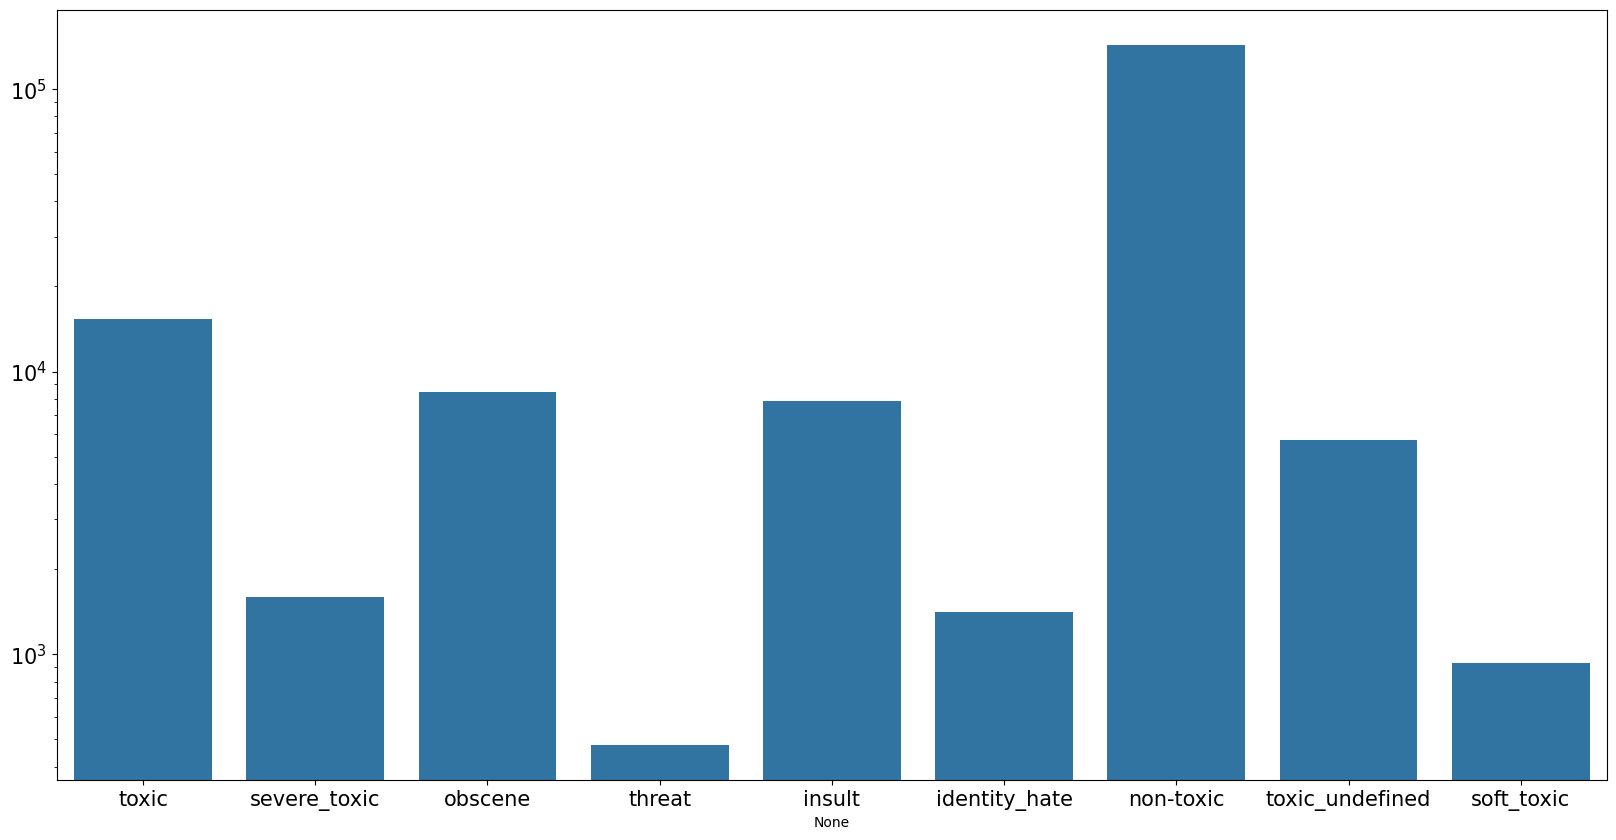

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
label_counts = df[analysis_columns].sum()
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=label_counts.index, y=label_counts.values)
ax.set_yscale("log")
ax.tick_params(labelsize=15)

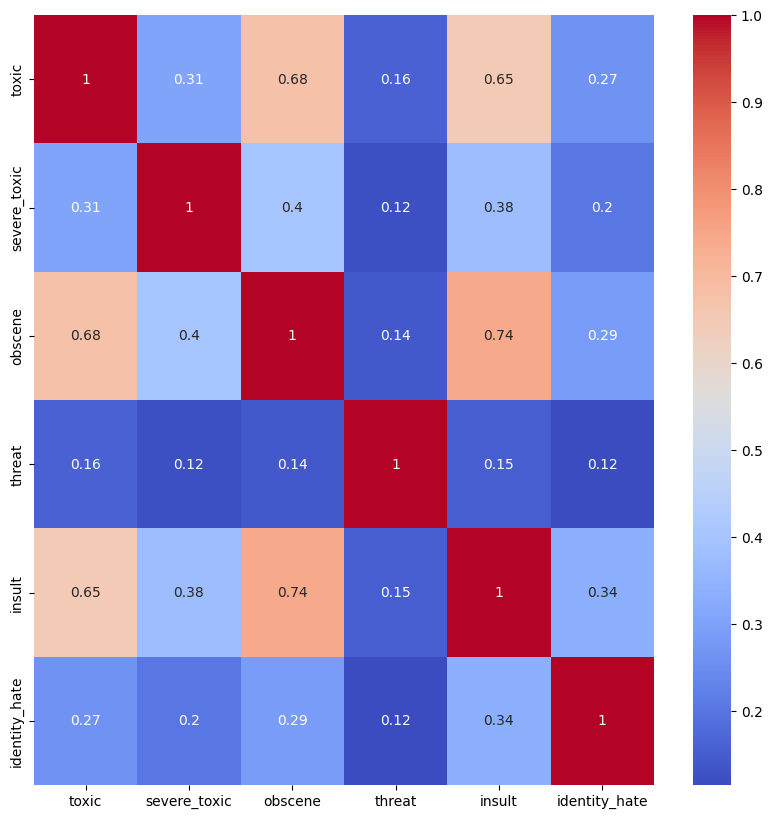

In [27]:
# Visualise any correlations between labels:
# It seems there are some strong correlations between labels
heatmap_data = df[target_columns]
plt.figure(figsize=(10, 10))
ax = sns.heatmap(heatmap_data.corr(), cmap='coolwarm', annot=True)
ax.tick_params(labelsize=10)

In [30]:
# Confirm that all severly toxic comments (n=1595) are toxic:
df.loc[df['severe_toxic']==1,'toxic'].sum()

1595

In [32]:
print(type(df))
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'non-toxic', 'toxicity_type_defined',
       'toxic_undefined', 'soft_toxic'],
      dtype='object')


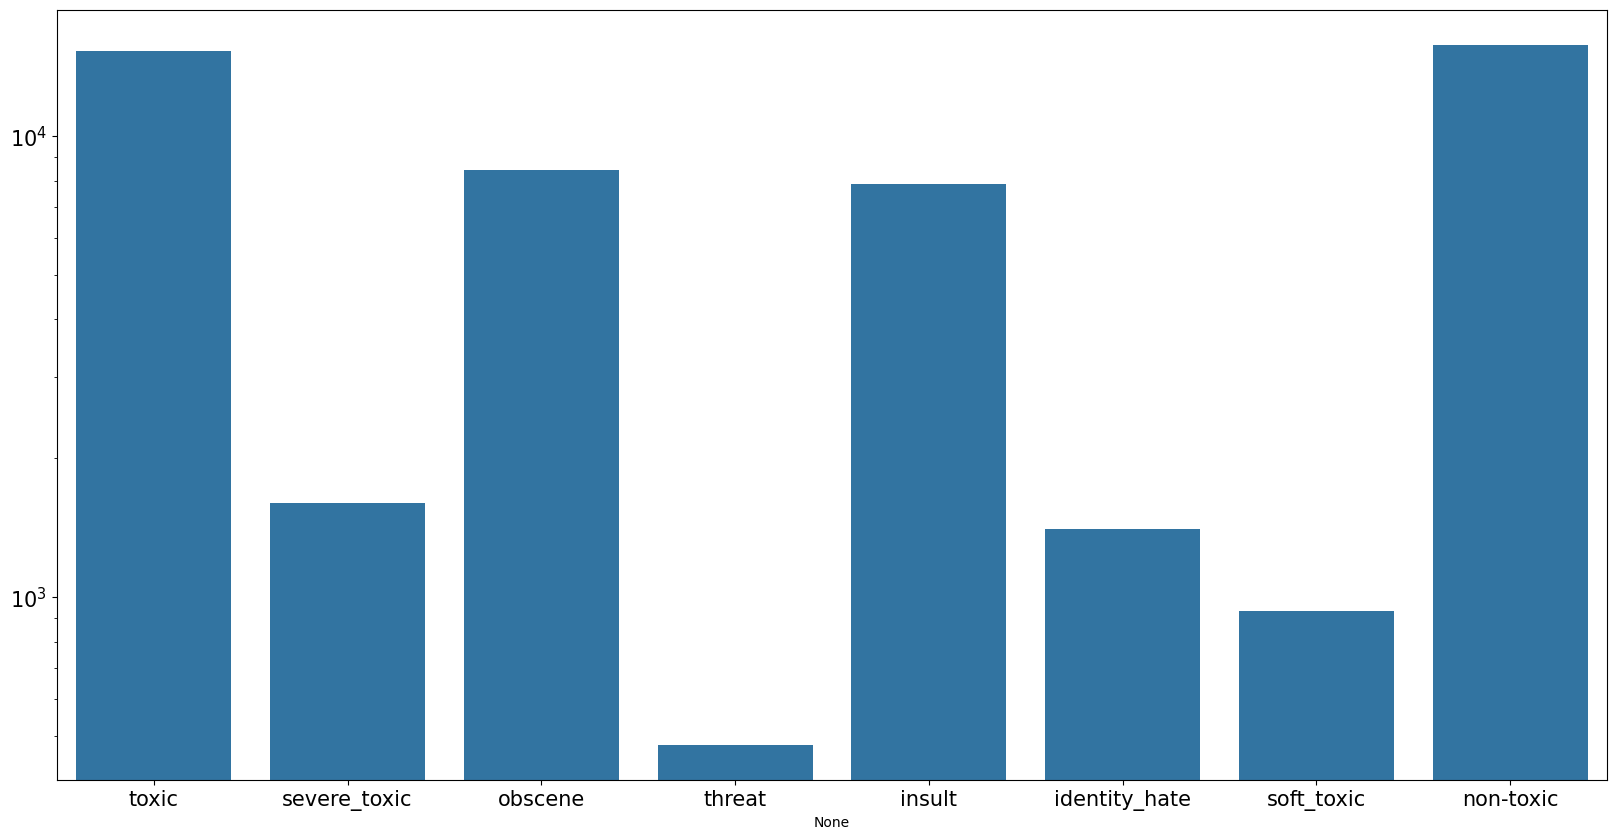

In [38]:
import pandas as pd

# Define train_balanced
train_balanced = pd.concat([df[df['non-toxic'] == 1].sample(frac=0.11), df.loc[df['non-toxic'] == 0]])

# Shuffle the DataFrame
train_balanced = train_balanced.sample(frac=1)

# Define target_columns
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'soft_toxic']

# Now you can proceed with using train_balanced and target_columns
label_counts = train_balanced[target_columns + ['non-toxic']].sum()
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=label_counts.index, y=label_counts.values)
ax.set_yscale("log")
ax.tick_params(labelsize=15)

In [46]:
all_tokens = []
lemmas = []
nonstop_tokens = []
total_number_of_tokens = []
number_of_sentences = []
number_of_puncts = []
glove_vector = []

for doc in nlp.pipe(train_balanced['comment_text'].astype('unicode').values, batch_size=50):
    if doc.has_annotation("DEP"):
        all_tokens.append([t.lower_ for t in doc])
        nonstop_tokens.append([t.lower_ for t in doc if t.is_alpha and not t.is_stop])
        lemmas.append([t.lemma_ for t in doc if t.is_alpha and not t.is_stop])
        total_number_of_tokens.append(doc.__len__())
        number_of_sentences.append(sum(1 for _ in doc.sents))
        number_of_puncts.append(sum(1 for t in doc if t.is_punct))
        glove_vector.append(doc.vector.tolist())
    else:
        all_tokens.append(None)
        nonstop_tokens.append(None)
        lemmas.append(None)
        total_number_of_tokens.append(None)
        number_of_sentences.append(None)
        number_of_puncts.append(None)
        glove_vector.append(None)

train_balanced['all_tokens'] = all_tokens
train_balanced['nonstop_tokens'] = nonstop_tokens
train_balanced['lemmas'] = lemmas
train_balanced['total_number_of_tokens'] = total_number_of_tokens
train_balanced['number_of_sentences'] = number_of_sentences
train_balanced['number_of_puncts'] = number_of_puncts
train_balanced['glove_vector'] = glove_vector

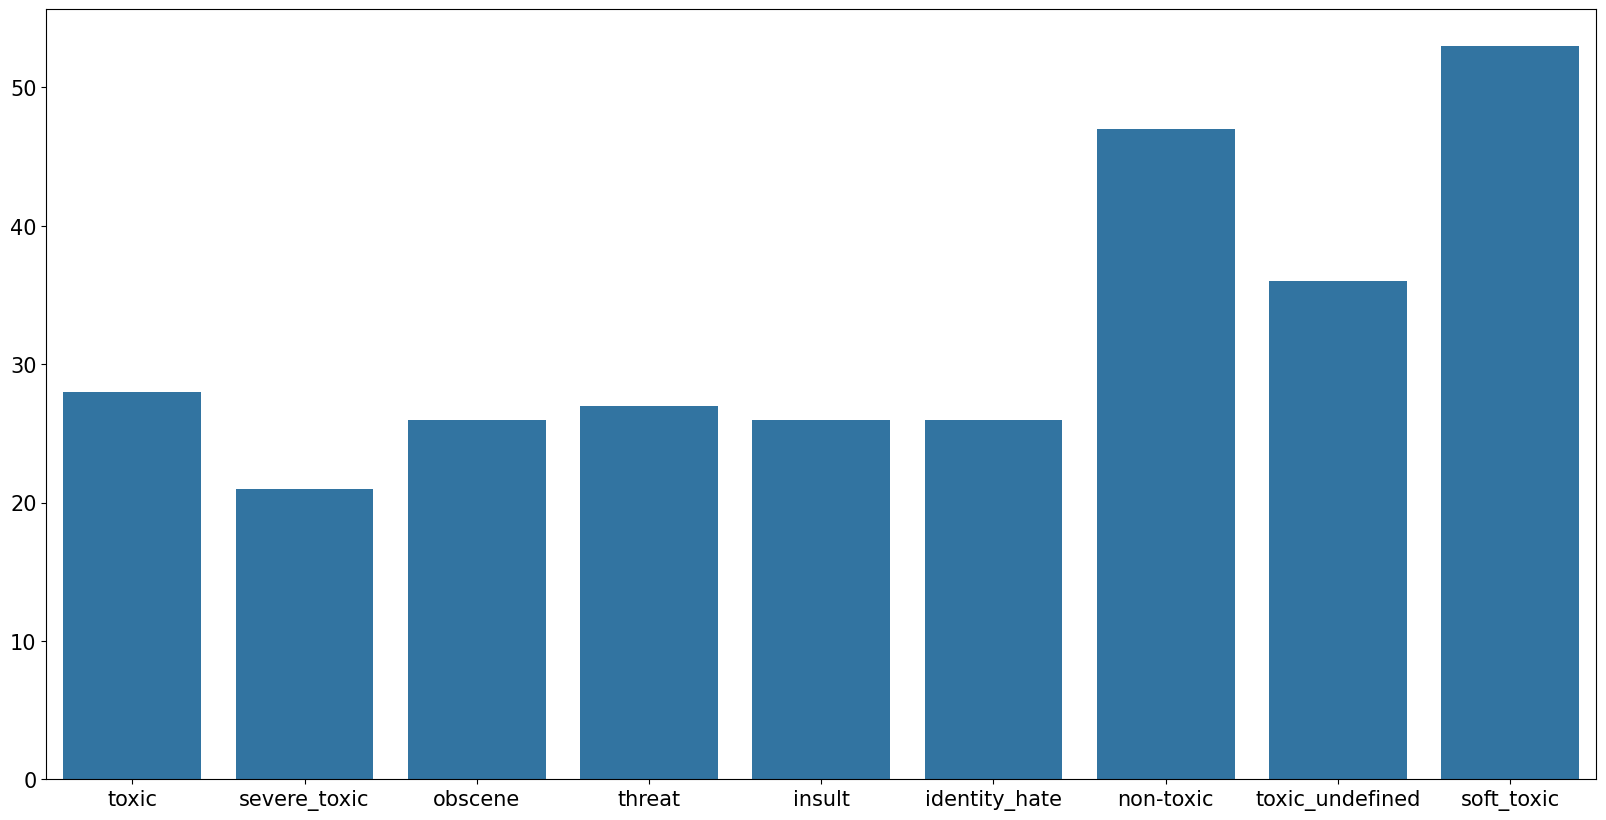

In [47]:
mc_length = []

for label in analysis_columns:
    mc_length.append(train_balanced.loc[train_balanced[label]==1,'total_number_of_tokens'].median())

plt.figure(figsize=(20, 10))
ax = sns.barplot(x=analysis_columns, y=mc_length)
ax.tick_params(labelsize=15)

In [49]:
import numpy as np

log_max = np.log(train_balanced['total_number_of_tokens'].max())
train_balanced['log_tokens'] = train_balanced['total_number_of_tokens']**(1/log_max)
upper = train_balanced['log_tokens'].max()
train_balanced['log_tokens_normalised'] = (train_balanced['log_tokens'])/(upper)
#helpful_log_max_root = df.Helpful_Votes**(1/log_maxlog_max

<ipython-input-51-46863018d5b7>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
<ipython-input-51-46863018d5b7>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
<ipython-input-51-46863018d5b7>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
<ipython-input-51-46863018d5b7>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
<ipython-input-51-46863018d5b7>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
<ipython-input-51-46863018d5b7>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotatio

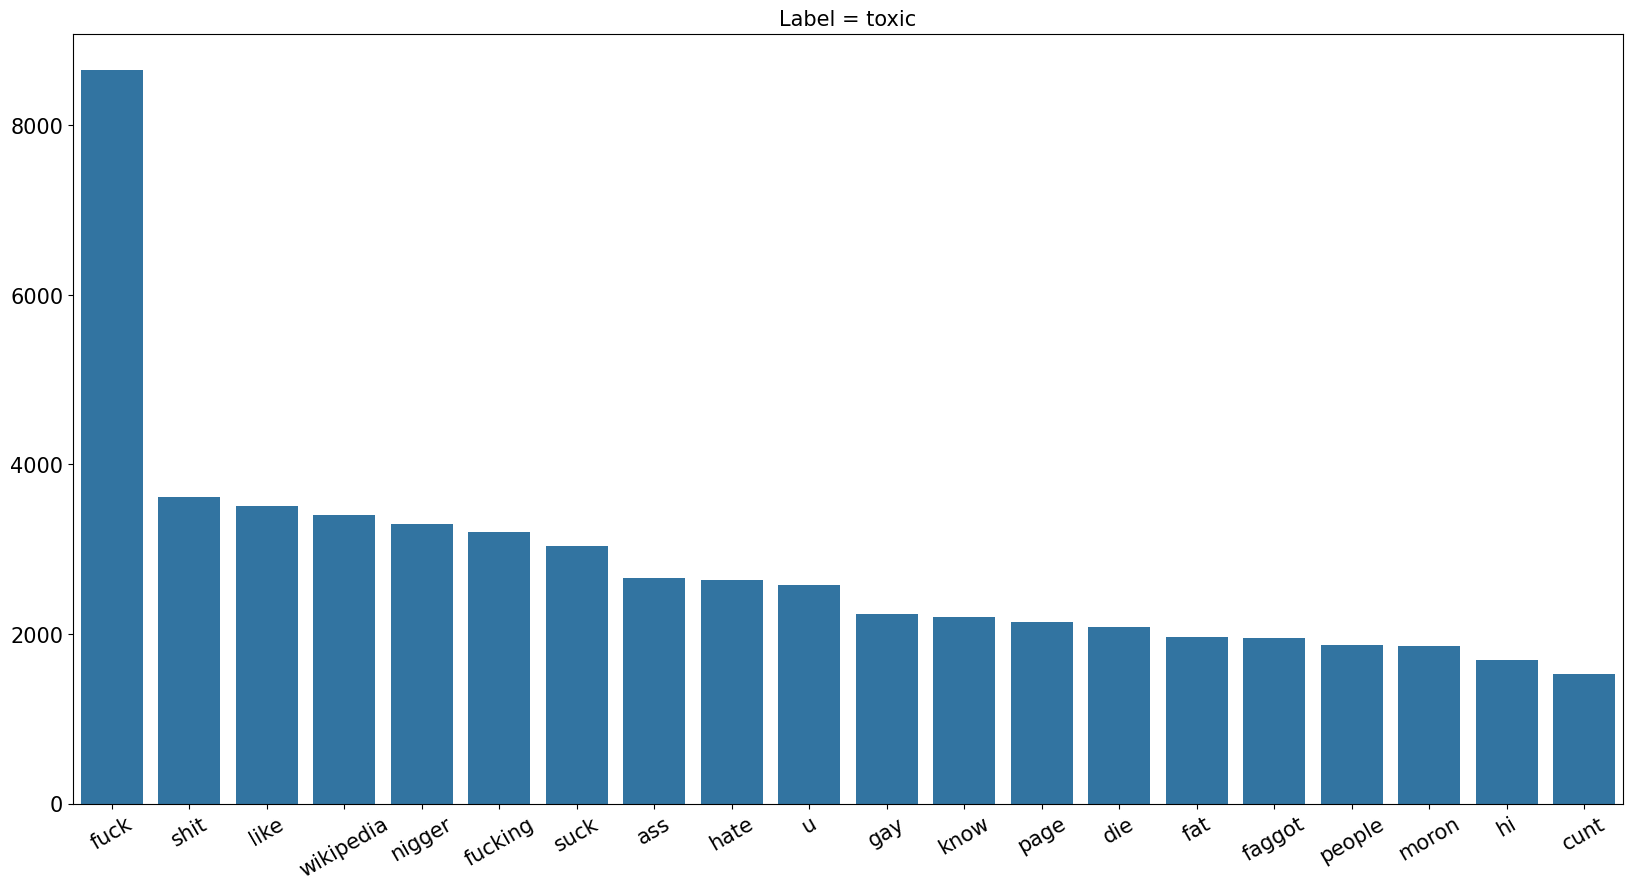

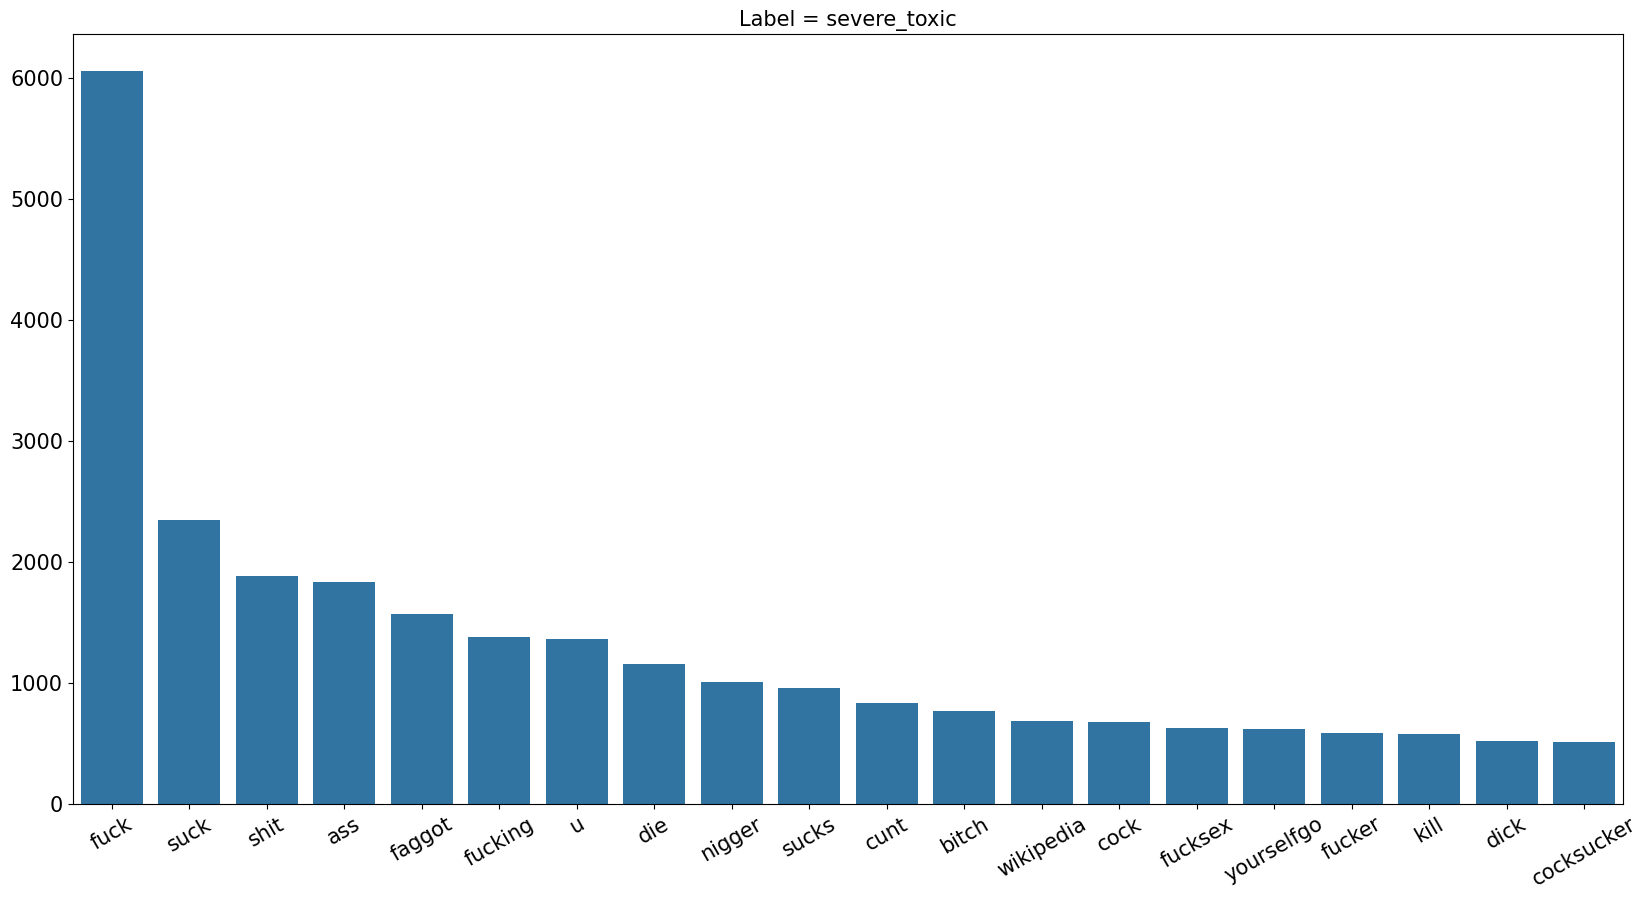

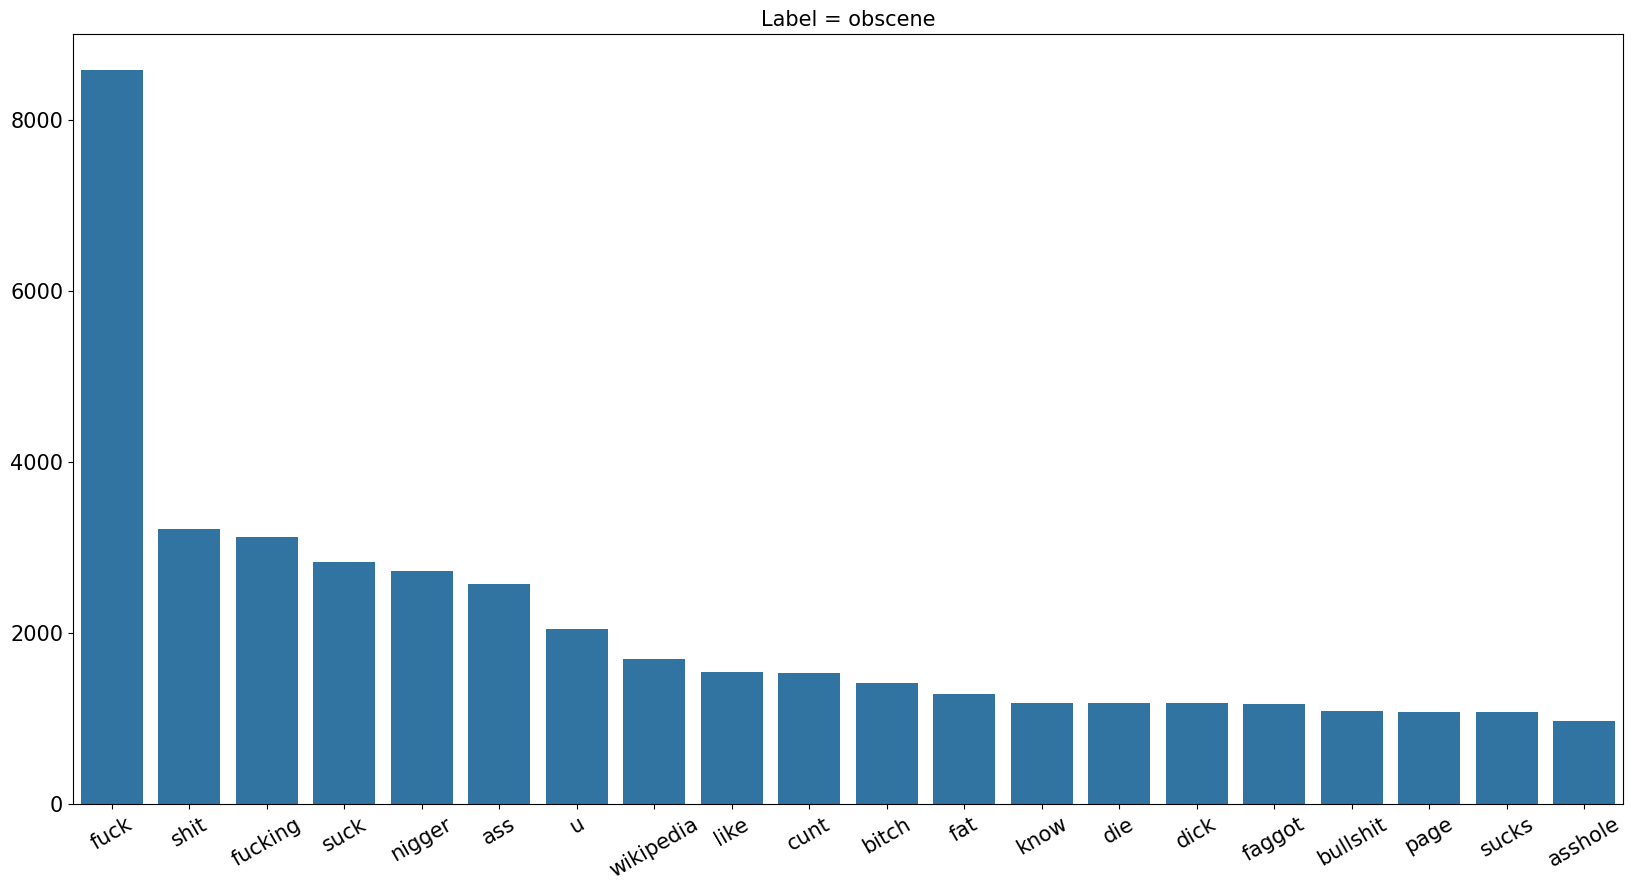

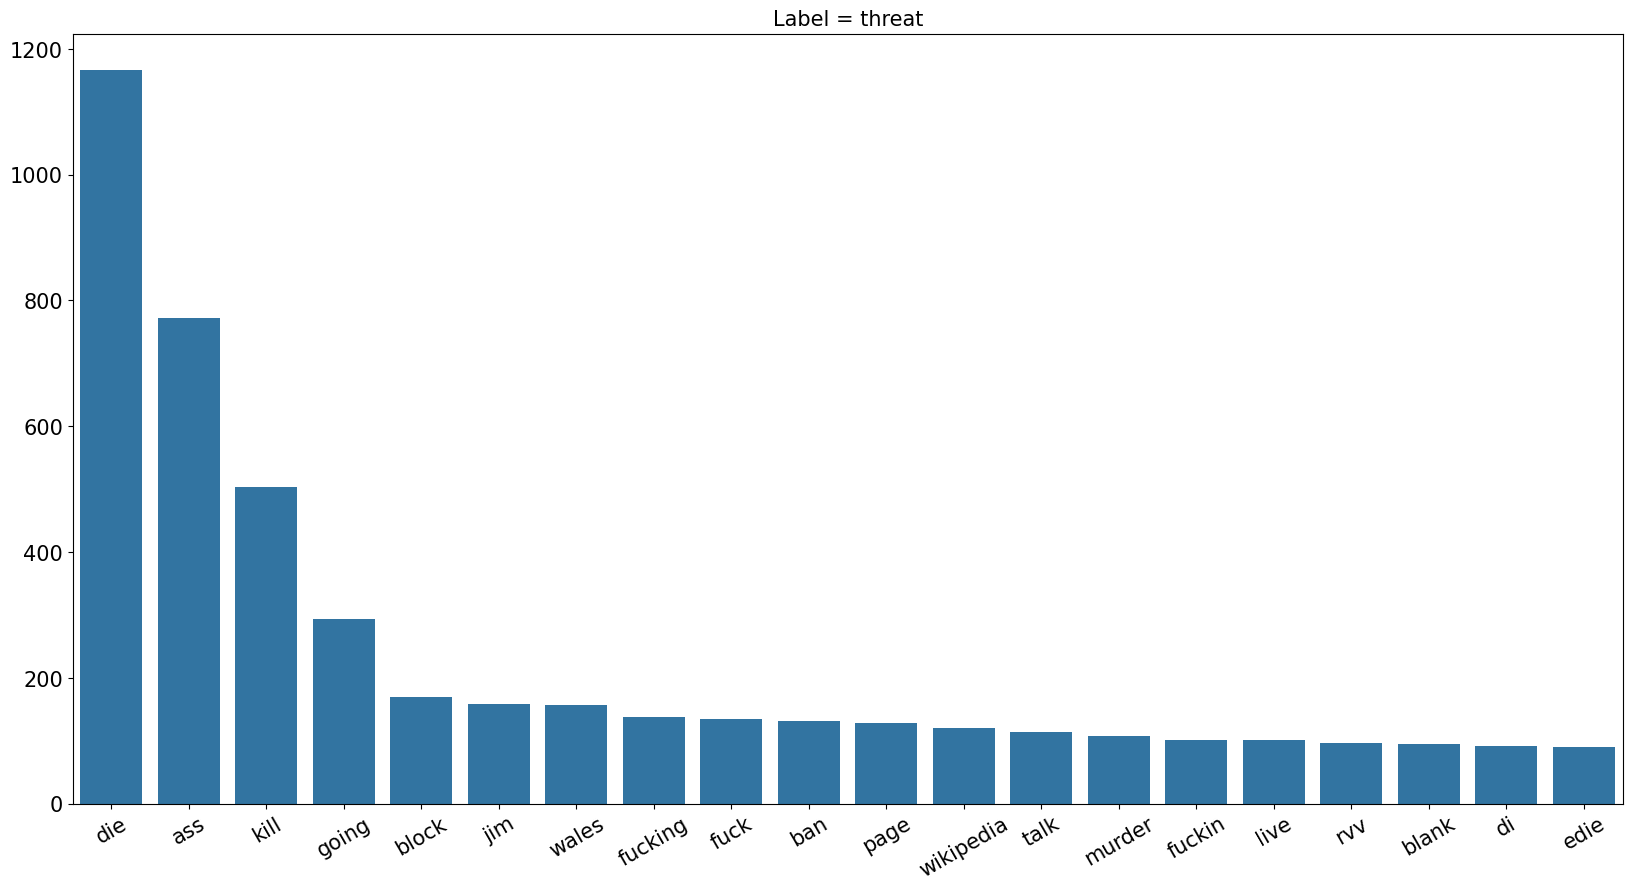

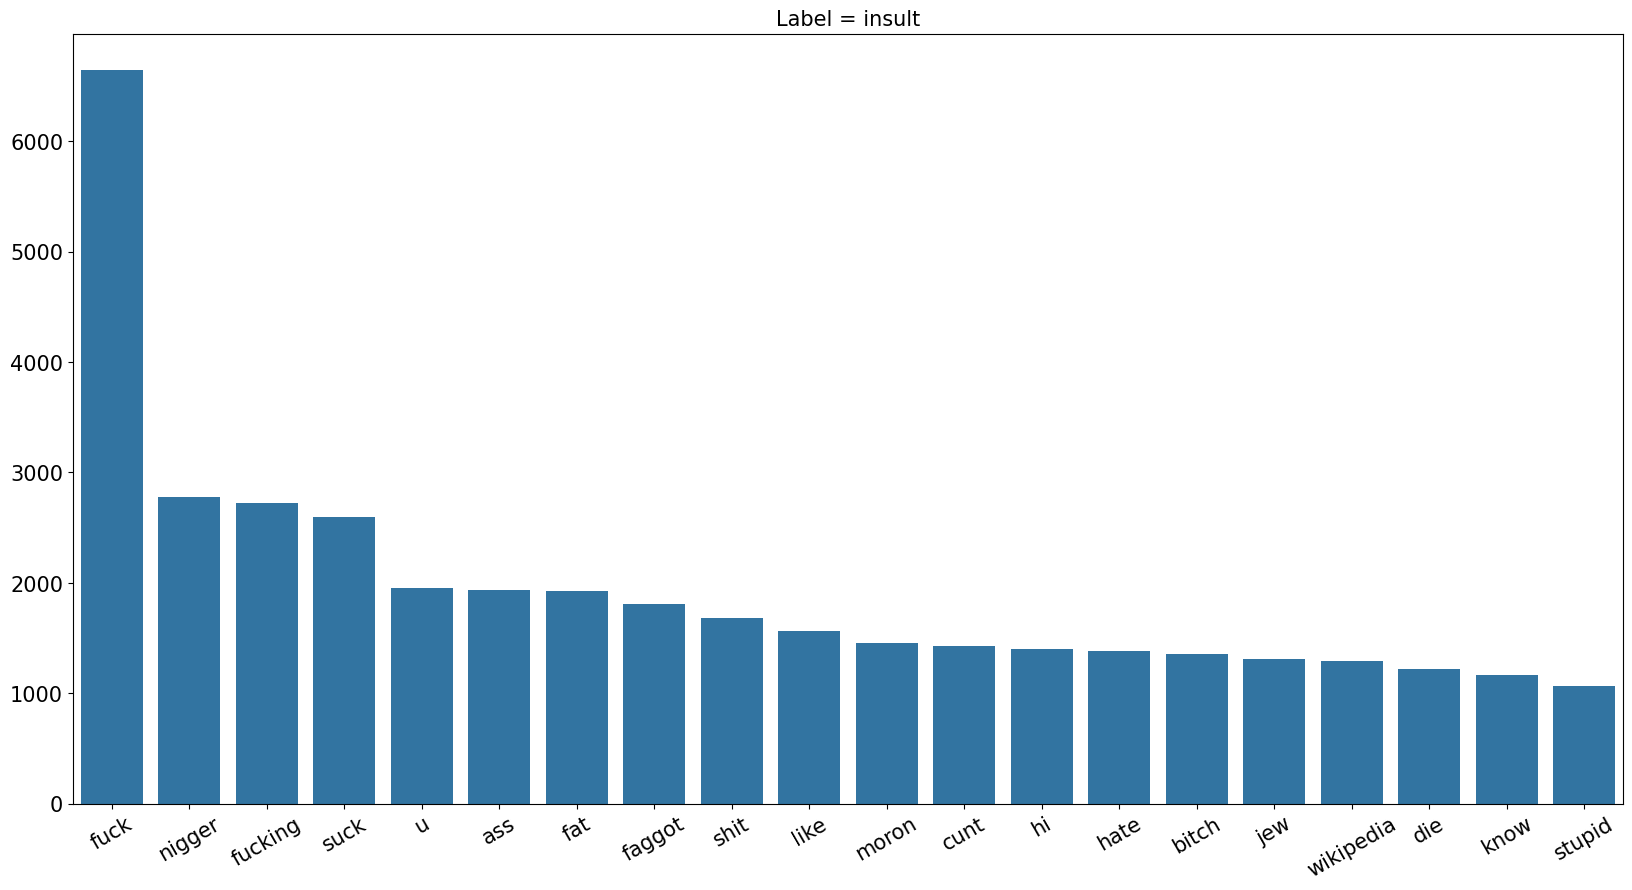

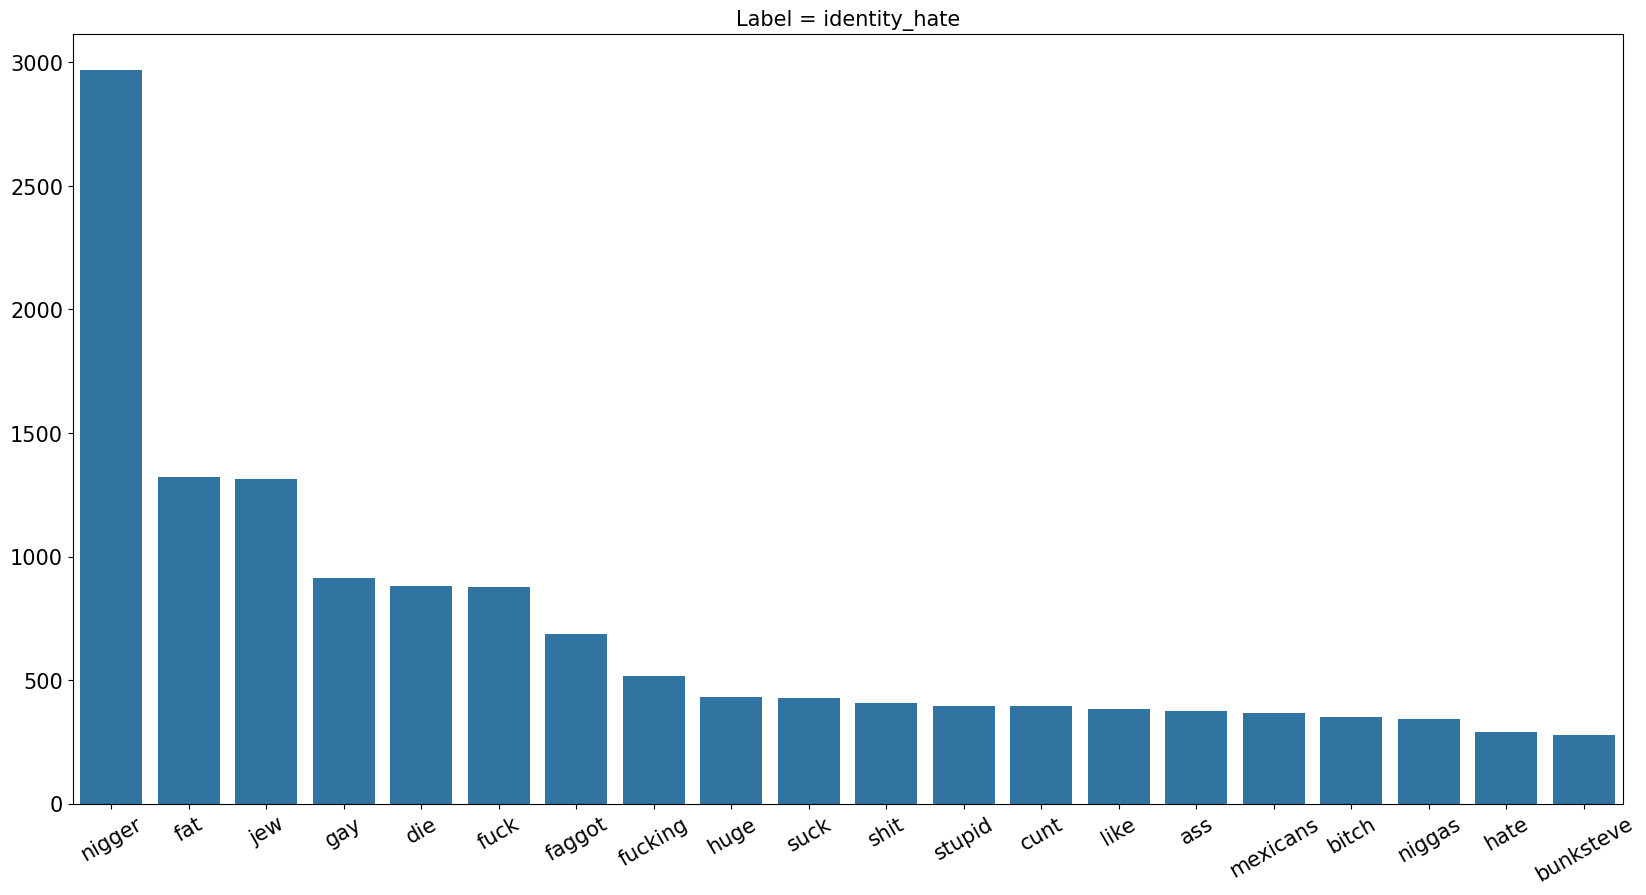

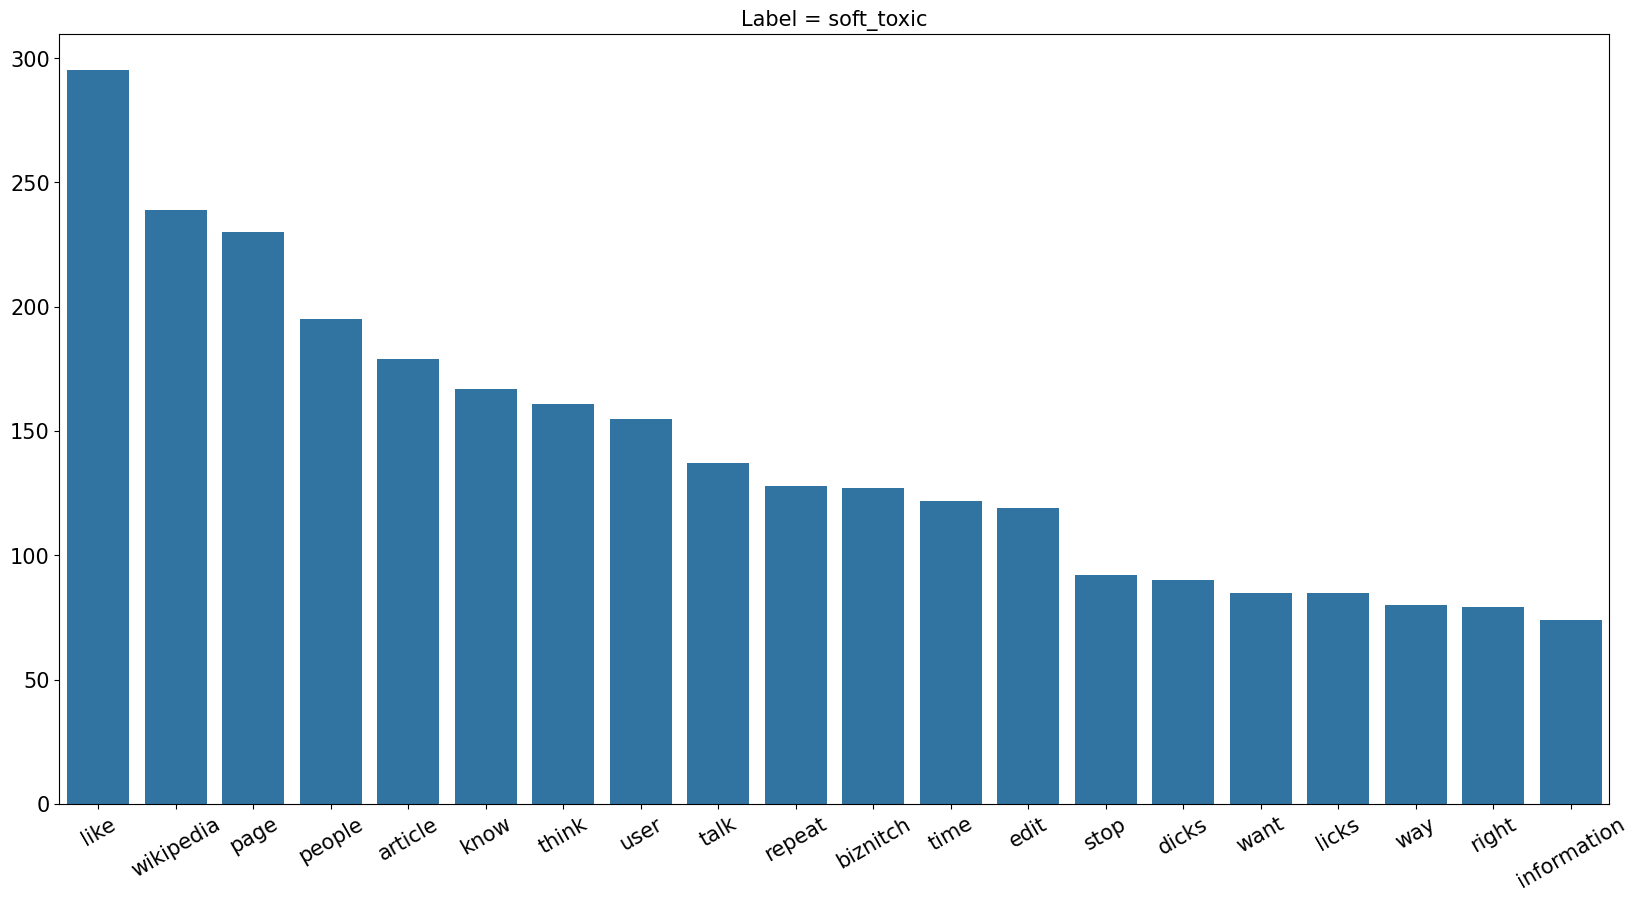

In [51]:
import collections

for label in target_columns:
    word_list = list(train_balanced.loc[train_balanced[label]==1, 'nonstop_tokens'].explode())
    most_common = collections.Counter(word_list).most_common(20)
    words = [w for w,_ in most_common]
    counts = [c for _,c in most_common]
    plt.figure(figsize=(20, 10))
    ax = sns.barplot(x=words, y=counts)
    ax.set_title(f'Label = {label}', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenizing and encoding the sentences
def tokenize_sentences(sentences):
    return tokenizer.batch_encode_plus(
        sentences,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors='pt'
    )

encoded_data = tokenize_sentences(df['comment_text'].values)
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']

# Convert labels into tensors
labels = torch.tensor(df['toxic'].values)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.1
)
train_masks, val_masks = train_test_split(attention_masks, test_size=0.1)

# Create dataloaders
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = DataLoader(train_data, batch_size=16, shuffle=True)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = DataLoader(val_data, batch_size=16, shuffle=False)


In [7]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [8]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 5
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    # Training
    model.train()
    total_loss = 0
    for batch in train_sampler:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_sampler)
    print(f'Average training loss: {avg_train_loss}')

    # Validation
    model.eval()
    val_preds = []
    with torch.no_grad():
        for batch in val_sampler:
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    print(f'Validation Accuracy: {val_acc}')


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5
Average training loss: 0.12158228909631974
Validation Accuracy: 0.9624639679157789
Epoch 2/5
Average training loss: 0.08848283379401843
Validation Accuracy: 0.94949241759619
Epoch 3/5
Average training loss: 0.05797367486748092
Validation Accuracy: 0.958704098257927
Epoch 4/5
Average training loss: 0.03518929478200813
Validation Accuracy: 0.9597067301666875
Epoch 5/5
Average training loss: 0.02644604741726896
Validation Accuracy: 0.9571374859004887


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Make predictions on the validation set
predictions = []
labels = []
model.eval()

with torch.no_grad():
    for batch in val_sampler:
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels_batch = batch
        outputs = model(inputs, attention_mask=masks)
        predictions.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        labels.extend(labels_batch.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# You can also print a full classification report for more detailed analysis
print("\nClassification Report:")
print(classification_report(labels, predictions, target_names=['Non-Toxic', 'Toxic']))


Accuracy: 0.9571374859004887
Precision: 0.7784011220196353
Recall: 0.7510148849797023
F1 Score: 0.7644628099173554

Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.97      0.98      0.98     14480
       Toxic       0.78      0.75      0.76      1478

    accuracy                           0.96     15958
   macro avg       0.88      0.86      0.87     15958
weighted avg       0.96      0.96      0.96     15958

